# Correlation lengths - round 2

Created 02/12/2025

Objectives:
* Go more in depth on [this notebook](correlation_length.ipynb):
    * Should ensure consistency between methods.

# Imports

In [61]:
from functools import reduce

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [63]:
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

In [64]:
import h5py
from tenpy.tools import hdf5_io

import os

In [65]:
import sys

In [66]:
sys.path.append("../")

In [67]:
from SPTOptimization.utils import (
    get_transfer_matrix_from_unitary,
    multiply_transfer_matrices
)

In [68]:
import pickle

# Load data

In [69]:
DATA_DIR = r"data/transverse_cluster_200_site_dmrg"

In [70]:
loaded_data = list()

for local_file_name in os.listdir(DATA_DIR):
    f_name = r"{}/{}".format(DATA_DIR, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        loaded_data.append(data)

In [71]:
b_parameters = sorted(list(d['paramters']['B'] for d in loaded_data))

In [72]:
psi_dict = dict()

In [73]:
for b in b_parameters:
    psi = next(
        d['wavefunction']
        for d in loaded_data
        if d['paramters']['B'] == b
    )

    rounded_b = round(b, 1)
    psi_dict[rounded_b] = psi

# Initial tests

In [74]:
test_psi = psi_dict[0.5]

In [75]:
test_tm = (
    get_transfer_matrix_from_unitary(test_psi, 100)
    .combine_legs([['vR', 'vR*'], ['vL', 'vL*']])
    .to_ndarray()
)

In [76]:
np.linalg.eigvals(test_tm)

array([ 1.        +3.60141469e-17j,  0.99262633-6.43718570e-18j,
       -0.81667963+2.24548548e-17j,  0.68165188+5.41470732e-17j,
       -0.81671761+1.92126797e-17j, -0.4358438 +6.85323242e-17j,
       -0.33571146+3.30035610e-17j, -0.44737044-2.67301183e-17j,
        0.31360024-1.12802090e-16j, -0.31183672-2.13033102e-16j,
        0.31380393-1.17506425e-16j, -0.19414252+9.44187440e-17j,
        0.13678232+1.27679054e-01j,  0.18772291+7.54390635e-02j,
        0.2177274 +7.14693093e-03j,  0.2177274 -7.14693093e-03j,
        0.18772291-7.54390635e-02j,  0.13678232-1.27679054e-01j,
       -0.21104775+2.90223900e-18j, -0.15643413-2.93153936e-17j,
        0.21747391+2.08350201e-02j,  0.21747391-2.08350201e-02j,
       -0.05280738+1.10858427e-01j, -0.05280738-1.10858427e-01j,
       -0.15323067+4.06188101e-17j,  0.07248865+7.00305261e-02j,
        0.07248865-7.00305261e-02j, -0.08620203-6.27040571e-17j,
       -0.04515352+9.17770207e-02j, -0.04515352-9.17770207e-02j,
       -0.07339911+4.3091

In [77]:
-1/np.log(0.99262633)

135.11706074443174

In [78]:
test_tms = [
    get_transfer_matrix_from_unitary(p, 100)
    .combine_legs([['vR', 'vR*'], ['vL', 'vL*']])
    .to_ndarray()
    for p in psi_dict.values()
]

In [79]:
def get_corr_length(tm):
    eigs = np.linalg.eigvals(tm)
    l1 = np.abs(eigs[0])
    l2 = np.abs(eigs[1])
    return -1/np.log(l2/l1)

In [80]:
test_corr_lengths = [get_corr_length(tm) for tm in test_tms]

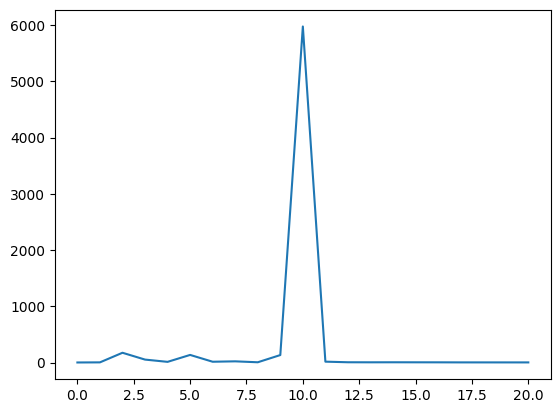

In [81]:
plt.plot(test_corr_lengths)

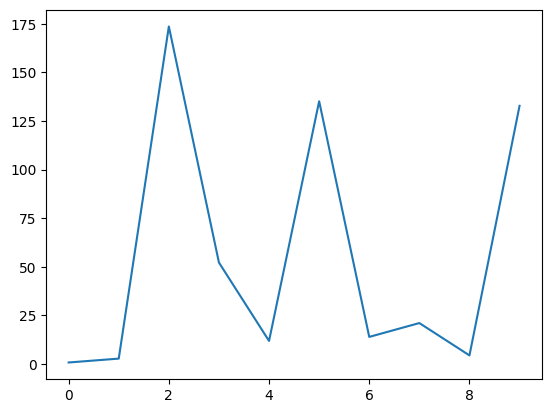

In [82]:
plt.plot(test_corr_lengths[:10])

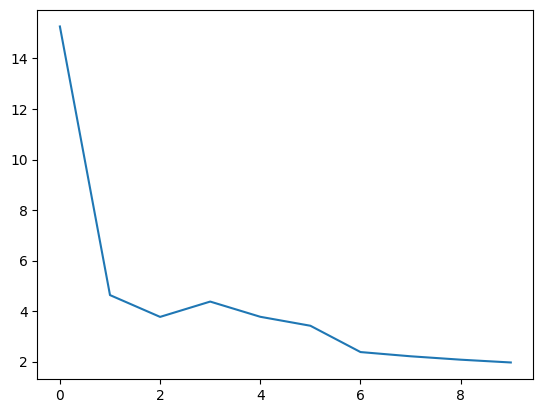

In [83]:
plt.plot(test_corr_lengths[11:])

In [84]:
test_psi.L

200

In [85]:
transfer_eigenvalues = list()

for p in psi_dict.values():
    tm = (
        get_transfer_matrix_from_unitary(p, 100)
        .combine_legs([['vR', 'vR*'], ['vL', 'vL*']])
        .to_ndarray()
    )

    eigs = np.linalg.eigvals(tm)
    transfer_eigenvalues.append(eigs[:2])

transfer_eigenvalues = np.array(transfer_eigenvalues)

In [86]:
transfer_eigenvalues

array([[ 1.00000000e+00+0.00000000e+00j, -2.62872575e-01+0.00000000e+00j],
       [ 1.00000000e+00+3.31201941e-19j,  6.93939165e-01+2.80981060e-18j],
       [ 1.00000000e+00-1.53069441e-18j,  9.94255845e-01-2.65212633e-18j],
       [ 1.00000000e+00+5.25160427e-19j,  9.81004751e-01-5.22936966e-19j],
       [ 1.00000000e+00+6.51537743e-18j,  9.18964382e-01-1.48226514e-17j],
       [ 1.00000000e+00+3.60141469e-17j,  9.92626329e-01-6.43718570e-18j],
       [ 1.00000000e+00-3.02958208e-19j,  9.30599381e-01-1.19779623e-19j],
       [ 1.00000000e+00+0.00000000e+00j,  9.53565223e-01+0.00000000e+00j],
       [ 1.00000000e+00+3.98986399e-17j, -7.96149326e-01-1.48427999e-02j],
       [ 1.00000000e+00+0.00000000e+00j,  9.92496973e-01+0.00000000e+00j],
       [ 1.00000000e+00+8.28374427e-19j,  9.99832738e-01+7.57535948e-19j],
       [ 1.00000000e+00+0.00000000e+00j,  9.36599115e-01+0.00000000e+00j],
       [ 1.00000000e+00+1.11022302e-16j, -8.05829137e-01-2.77555756e-16j],
       [ 1.00000000e+00-2

In [87]:
def get_cental_transfer_matrix(psi, num_sites=40):
    total_num_sites = psi.L

    left_site = (total_num_sites - num_sites)//2

    transfer_matrices = (
        get_transfer_matrix_from_unitary(psi, i)
        for i in range(left_site, left_site + num_sites)
    )

    overall_transfer_matrix = reduce(multiply_transfer_matrices, transfer_matrices)

    return overall_transfer_matrix

In [88]:
def get_corr_length(tm, num_sites=40):
    np_tm = (
        tm
        .combine_legs([['vR', 'vR*'], ['vL', 'vL*']])
        .to_ndarray()
    )

    eigs = np.sort(np.linalg.eigvals(np_tm))[::-1]
    l1 = np.abs(eigs[0])
    l2 = np.abs(eigs[1])
    return np.array([-num_sites/np.log(l2/l1), eigs[0]])

In [89]:
num_sites=60

In [90]:
test_big_tms = [
    get_cental_transfer_matrix(p, num_sites)
    for p in psi_dict.values()
]

In [91]:
test_big_corr_lengths = np.array([
    get_corr_length(tm, num_sites)
    for tm in test_big_tms
])

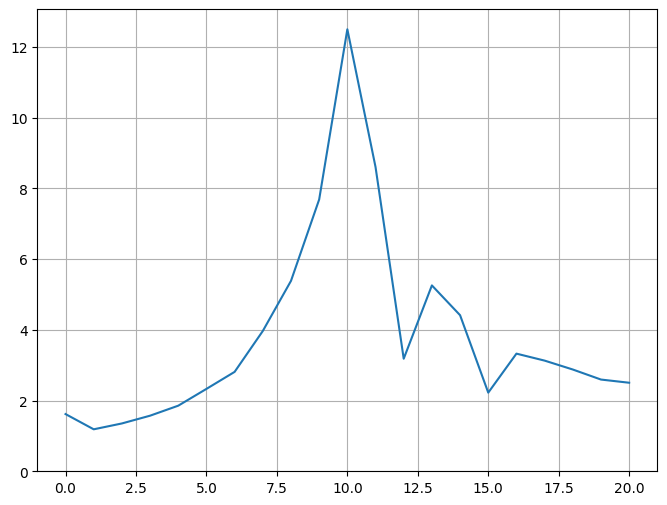

In [92]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(test_big_corr_lengths[:,0])

ax.set_ylim(bottom=0)
ax.grid()

In [93]:
test_big_corr_lengths[:,1]

array([1.+0.00000000e+000j, 1.+0.00000000e+000j, 1.+0.00000000e+000j,
       1.+0.00000000e+000j, 1.+0.00000000e+000j, 1.+0.00000000e+000j,
       1.+0.00000000e+000j, 1.+0.00000000e+000j, 1.+0.00000000e+000j,
       1.+0.00000000e+000j, 1.-7.71462980e-103j, 1.+0.00000000e+000j,
       1.-8.60957776e-042j, 1.-4.48415509e-044j, 1.+5.60519386e-045j,
       1.+0.00000000e+000j, 1.+0.00000000e+000j, 1.+0.00000000e+000j,
       1.+0.00000000e+000j, 1.+0.00000000e+000j, 1.-3.26265223e-055j])

Text(0.5, 1.0, 'Correlation length in the ZXZ model as a function of B')

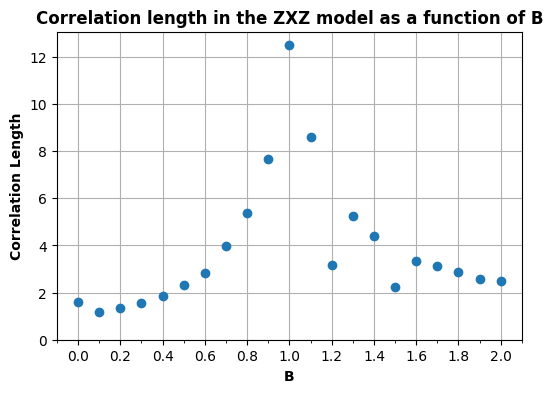

In [94]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(
    psi_dict.keys(),
    test_big_corr_lengths[:,0],
    'o'
)

ax.set_ylim(bottom=0)
ax.grid()

ax.set_xticks(np.array(list(psi_dict.keys())))

ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))

ax.set_xlabel("B", fontweight='bold')
ax.set_ylabel("Correlation Length", fontweight='bold')

ax.set_title("Correlation length in the ZXZ model as a function of B", fontweight='bold')

# From X expectation values

In [95]:
total_num_sites = 200
num_sites = 40

In [96]:
left_site = (total_num_sites - num_sites)//2
right_site = left_site + num_sites
(left_site, right_site)

(80, 120)

In [97]:
test_psi.expectation_value('Sx', [left_site, right_site])

array([0.12932601, 0.12932601])

In [98]:
x_exps = np.array([
    psi.expectation_value('Sx') for psi in psi_dict.values()
])

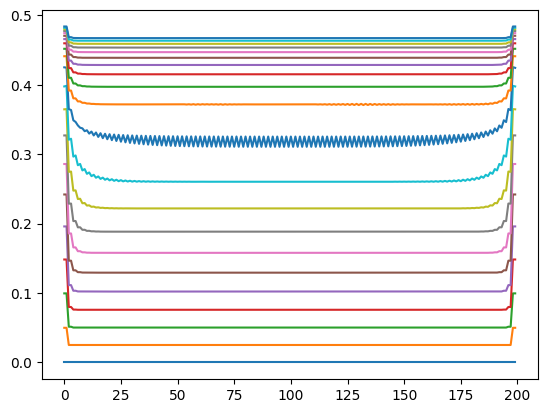

In [99]:
for l in x_exps:
    plt.plot(l)

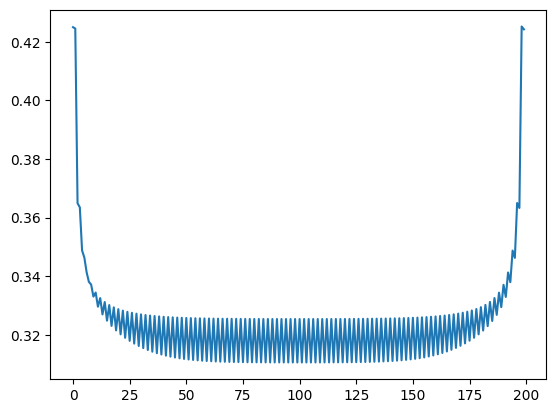

In [100]:
plt.plot(x_exps[10])

In [101]:
psi_dict[0.5].expectation_value_multi_sites(['Sx', 'Id', 'Id', 'Sx'], 99)

array(0.01672522)

In [102]:
def get_two_point_x_expectation(psi, distance):
    ops = ['Sx',] + ['Id',]*(distance-1) + ['Sx']

    return psi.expectation_value_multi_sites(ops, 80)

In [103]:
x_2_points = np.array([
    [get_two_point_x_expectation(psi, d) for d in range(41)]
    for psi in psi_dict.values()
])

In [104]:
x_2_points.shape

(21, 41)

In [105]:
sub_x_exps = x_exps[:,80:121]

In [106]:
sub_x_exps.shape

(21, 41)

In [107]:
x_correlations = (
    x_2_points
    - x_exps[:,80:81]*x_exps[:,80:121]
)

In [108]:
x_correlations.shape

(21, 41)

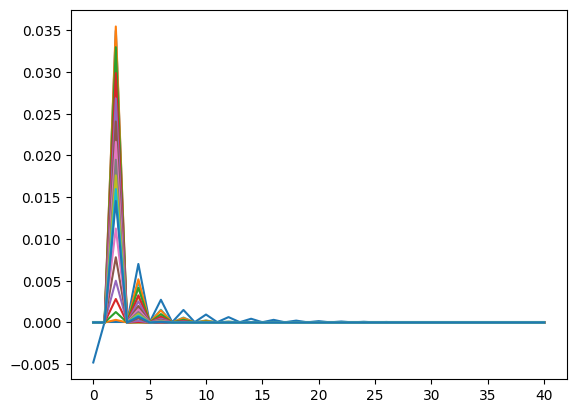

In [109]:
for l in x_correlations:
    plt.plot(l)

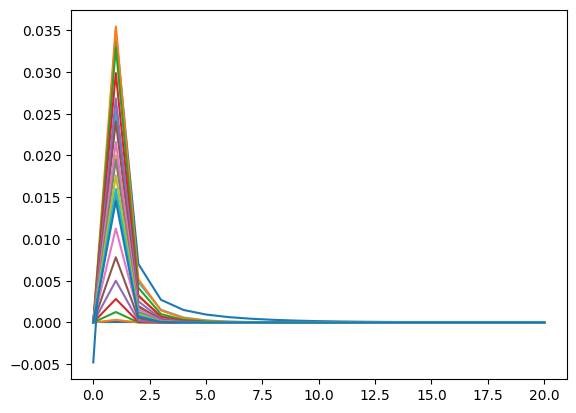

In [110]:
for l in x_correlations:
    plt.plot(l[::2])

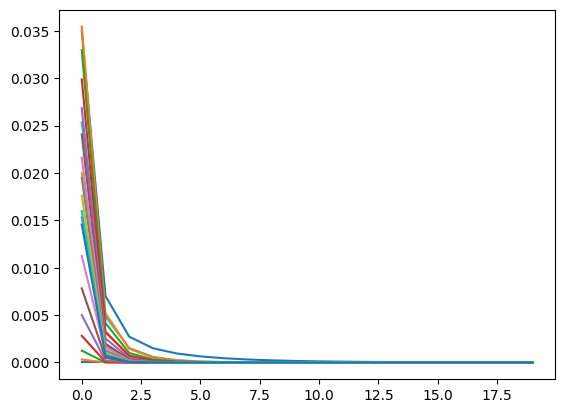

In [111]:
for l in x_correlations:
    plt.plot(l[2::2])

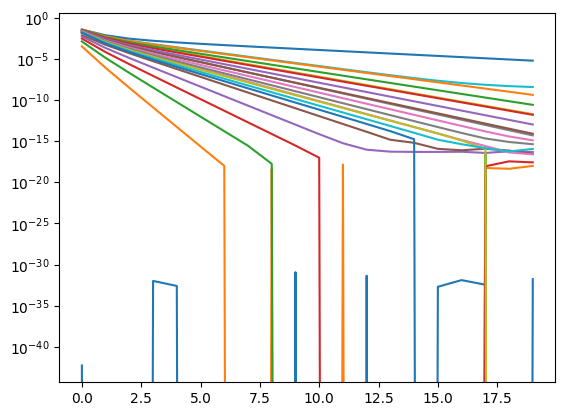

In [112]:
for l in x_correlations:
    plt.plot(l[2::2])

plt.yscale('log')

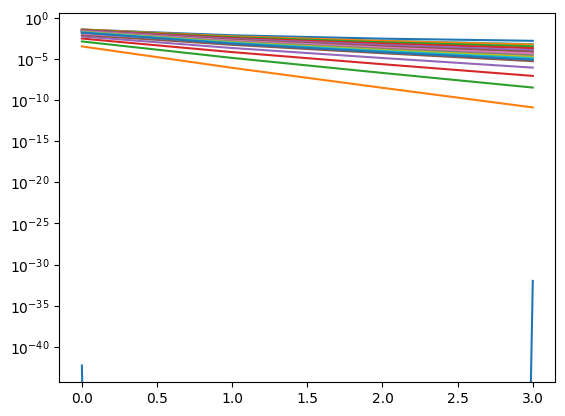

In [113]:
for l in x_correlations:
    plt.plot(l[2:10:2])

plt.yscale('log')

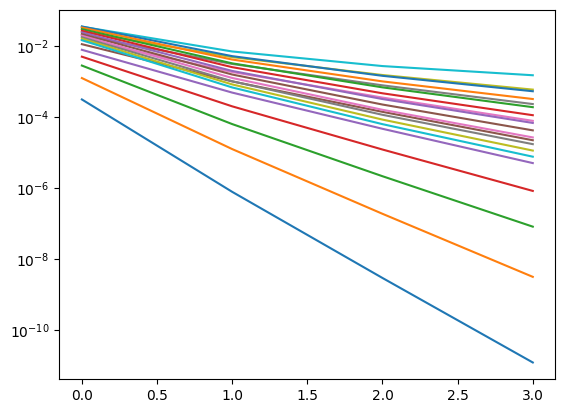

In [114]:
for l in x_correlations[1:]:
    plt.plot(l[2:10:2])

plt.yscale('log')

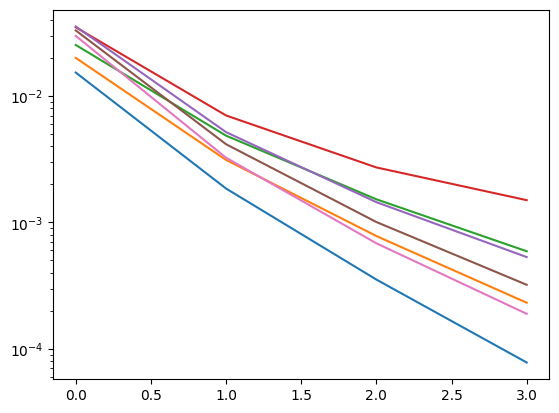

In [115]:
for l in x_correlations[7:14]:
    plt.plot(l[2:10:2])

plt.yscale('log')

In [116]:
np.log(x_correlations[10,2]/x_correlations[10,8])

3.148510758100284

In [117]:
correlation_lengths = 6/np.log(x_correlations[:,2]/x_correlations[:,8])

In [118]:
correlation_lengths[0] = 0

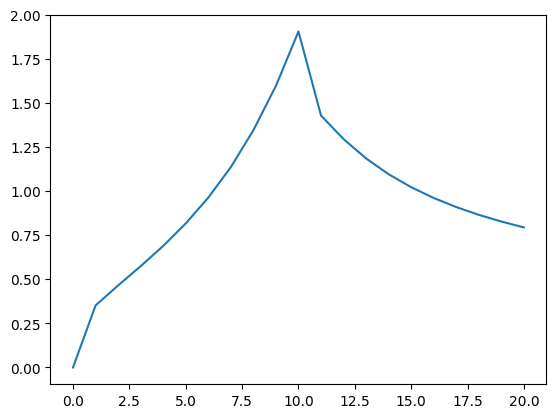

In [119]:
plt.plot(correlation_lengths)

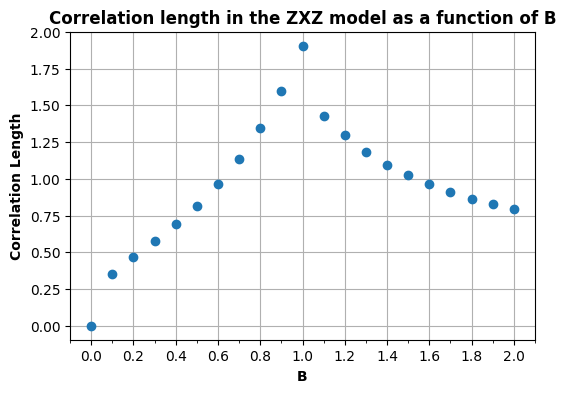

In [120]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(
    psi_dict.keys(),
    correlation_lengths,
    'o'
)

ax.grid()

ax.set_xticks(np.array(list(psi_dict.keys())))

ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))

ax.set_xlabel("B", fontweight='bold')
ax.set_ylabel("Correlation Length", fontweight='bold')

ax.set_title("Correlation length in the ZXZ model as a function of B", fontweight='bold')

fig.savefig(r'plots/correlation_length_zxz_model.png', dpi=200)

In [121]:
with open(r'make_plots/data/200_site_mps_correlation_lengths.pkl', 'wb') as f:
    pickle.dump(
        {
            'b_parameters': list(psi_dict.keys()),
            'correlation_lengths': correlation_lengths
        },
        f
    )

In [122]:
x_correlations.shape

(21, 41)

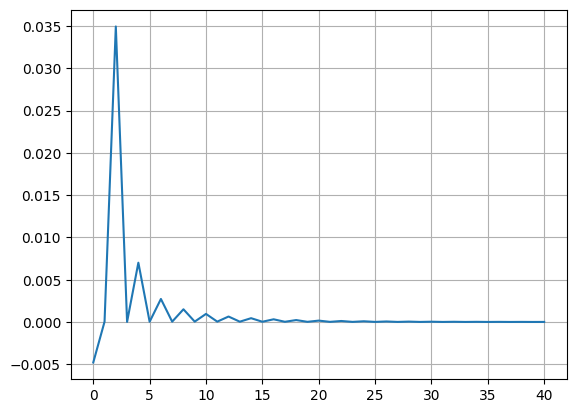

In [123]:
plt.plot(x_correlations[10])
plt.grid()

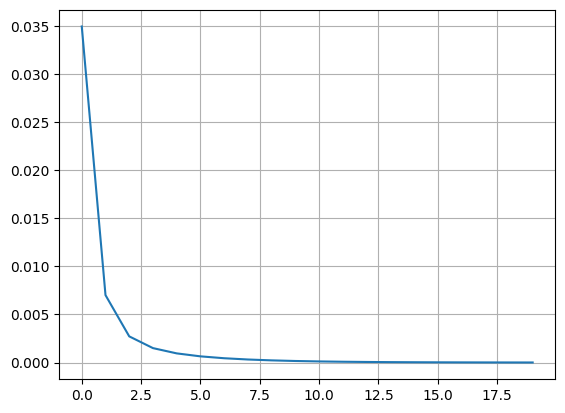

In [124]:
plt.plot(x_correlations[10,2::2])
plt.grid()

In [125]:
test_corr_length = correlation_lengths[10]

In [126]:
a = x_correlations[10, 2]

In [127]:
test_data = [
    a*np.exp(-i/test_corr_length) for i in range(40)
]

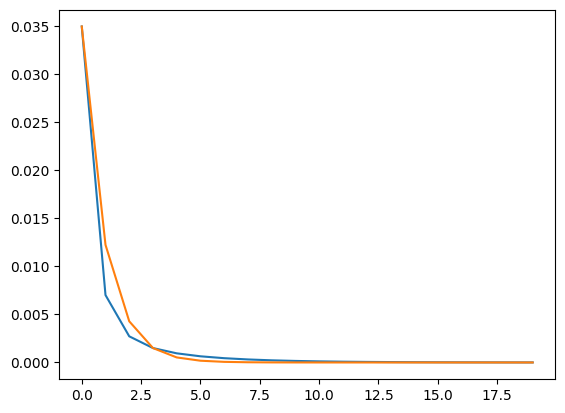

In [128]:
plt.plot(x_correlations[10,2::2])
plt.plot(test_data[::2])

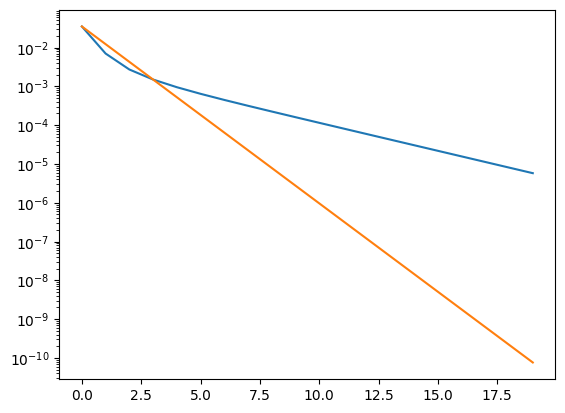

In [75]:
plt.plot(x_correlations[10,2::2])
plt.plot(test_data[::2])

plt.yscale('log')

In [76]:
def find_correlation_length(correlations, threshold=1e-13):
    values = [c for c in correlations if c > threshold]

    if len(values) > 10:
        values = values[-10:]

    corr_length = len(values)/np.log(values[0]/values[-1])

    return corr_length

In [77]:
x_correlations[0]

array([-3.19319185e-30,  4.24957801e-30,  5.72430423e-43,  1.88811230e-32,
       -2.15609067e-32, -1.43938251e-31, -1.91869547e-33,  1.87804685e-32,
        1.05519162e-32, -2.93899879e-32,  2.60186512e-33,  2.30366933e-32,
       -7.71554934e-42,  3.28744535e-32, -2.91192049e-33, -9.79241155e-33,
       -3.29209371e-32,  2.44469134e-33, -7.06254426e-43,  5.03977537e-32,
        1.21148067e-31,  5.99366934e-35, -1.97136999e-32, -8.77933548e-33,
       -5.18758164e-33,  3.20830517e-34,  4.53644256e-32, -9.92746107e-33,
       -4.84084227e-33,  1.20695925e-33, -3.96458613e-32,  8.38206644e-32,
        2.03915021e-33, -2.74863248e-32,  1.32232953e-32,  1.04933195e-33,
        3.65793636e-33, -2.56712244e-32, -9.12300369e-32,  3.68456425e-34,
        1.73514424e-32])

In [78]:
adjusted_corr_lengths = [0,] + [
    2*find_correlation_length(l[2::2]) for l in x_correlations[1:]
]

Text(0.5, 1.0, 'Correlation length in the ZXZ model as a function of B')

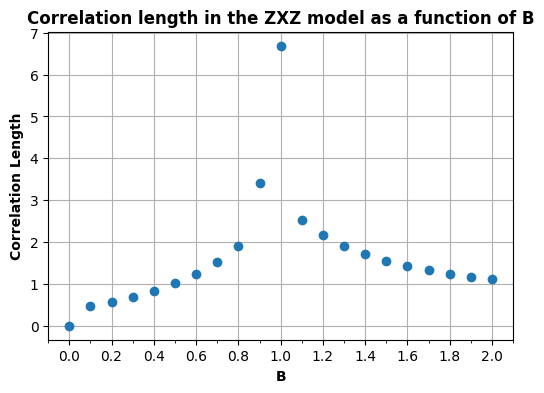

In [79]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(
    psi_dict.keys(),
    adjusted_corr_lengths,
    'o'
)

ax.grid()

ax.set_xticks(np.array(list(psi_dict.keys())))

ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))

ax.set_xlabel("B", fontweight='bold')
ax.set_ylabel("Correlation Length", fontweight='bold')

ax.set_title("Correlation length in the ZXZ model as a function of B", fontweight='bold')

## Fit function

In [150]:
X = x_correlations[10,2::2]

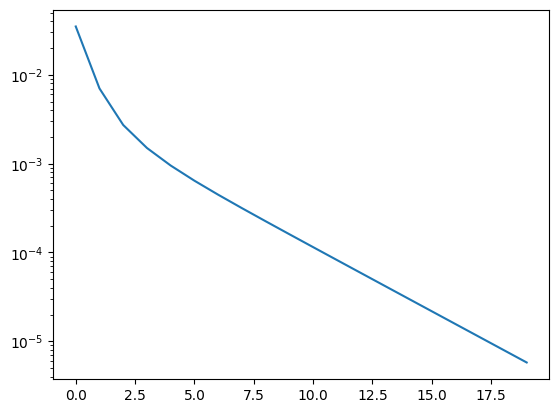

In [132]:
plt.plot(X)
plt.yscale('log')

In [133]:
def correlation_hypothesis(x, a, b, c):
    return c*np.exp(-a*x)/(x**b)

In [136]:
popt, pcov = curve_fit(
    correlation_hypothesis,
    np.arange(1,21),
    X
)

In [137]:
popt

array([-0.01239452,  2.33010517,  0.03451315])

In [139]:
-1/popt[0]

80.68080445434695

In [140]:
fit_data = list()

for n in np.arange(1,21):
    out = correlation_hypothesis(n, *popt)
    fit_data.append(out)

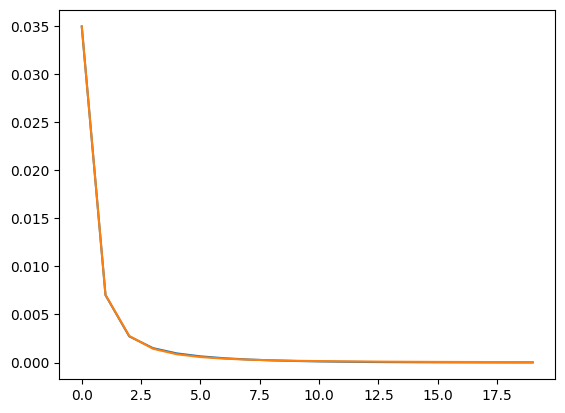

In [141]:
plt.plot(X)
plt.plot(fit_data)

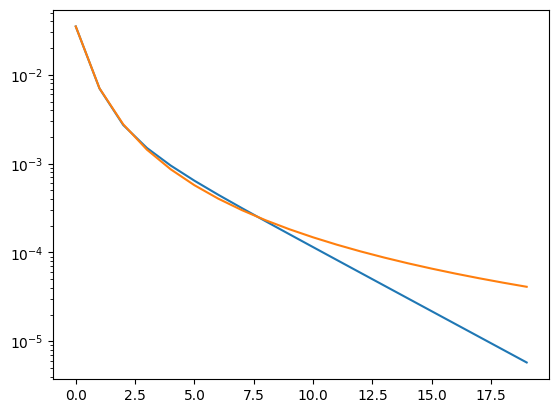

In [142]:
plt.plot(X)
plt.plot(fit_data)

plt.yscale('log')

In [143]:
def log_correlation_hypothesis(x, a, b, c):
    return np.log(correlation_hypothesis(x, a, b, c))

In [144]:
popt, pcov = curve_fit(
    log_correlation_hypothesis,
    np.arange(1,21),
    np.log(X)
)

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_86982/856083680.py:2: RuntimeWarning: invalid value encountered in log
  return np.log(correlation_hypothesis(x, a, b, c))


In [145]:
popt

array([0.19925501, 1.49462824, 0.03257435])

In [146]:
-1/popt[0]

-5.018694297511873

In [147]:
fit_data = list()

for n in np.arange(1,21):
    out = log_correlation_hypothesis(n, *popt)
    fit_data.append(out)

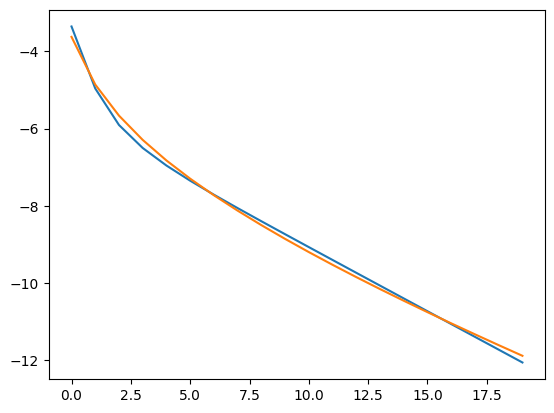

In [148]:
plt.plot(np.log(X))
plt.plot(fit_data)

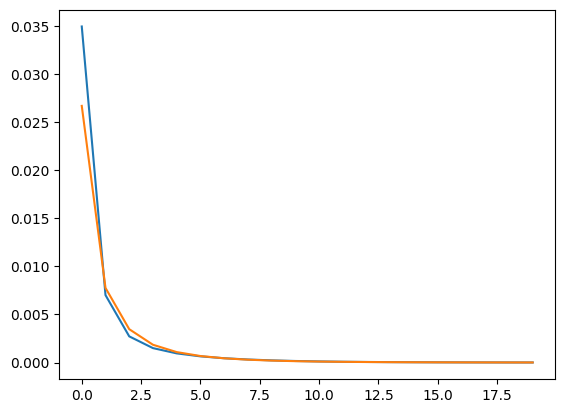

In [149]:
plt.plot(X)
plt.plot(np.exp(fit_data))

In [138]:
pcov

array([[ 1.67697063e-04, -2.99990146e-04,  5.75406458e-06],
       [-2.99990146e-04,  5.94559439e-04, -1.02180713e-05],
       [ 5.75406458e-06, -1.02180713e-05,  1.99690727e-07]])

### Sweep

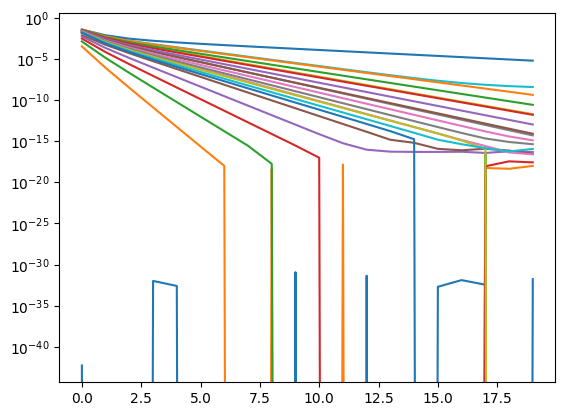

In [152]:
for vals in x_correlations[:, 2::2]:
    plt.plot(vals)

plt.yscale('log')

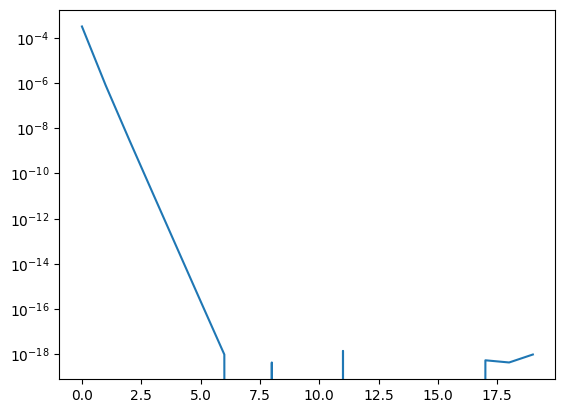

In [153]:
plt.plot(x_correlations[1, 2::2])

plt.yscale('log')

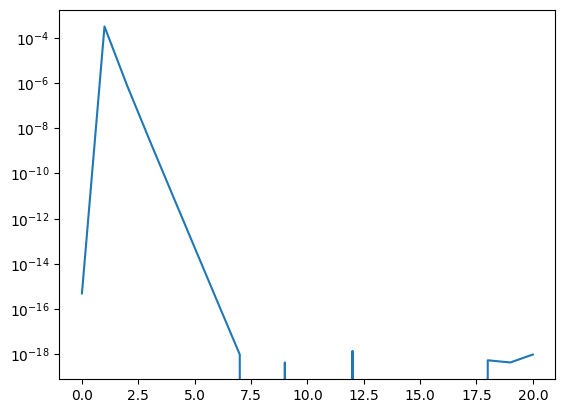

In [155]:
plt.plot(x_correlations[1, ::2])

plt.yscale('log')

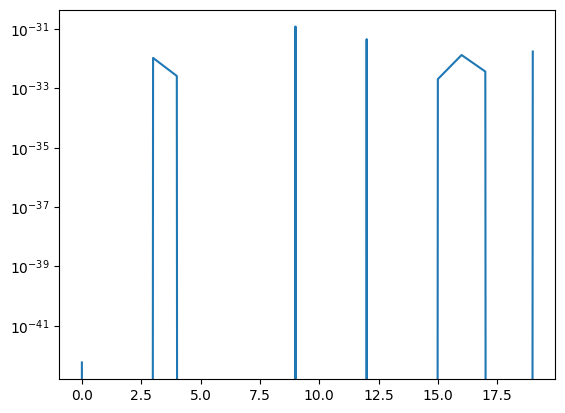

In [157]:
plt.plot(x_correlations[0, 2::2])

plt.yscale('log')

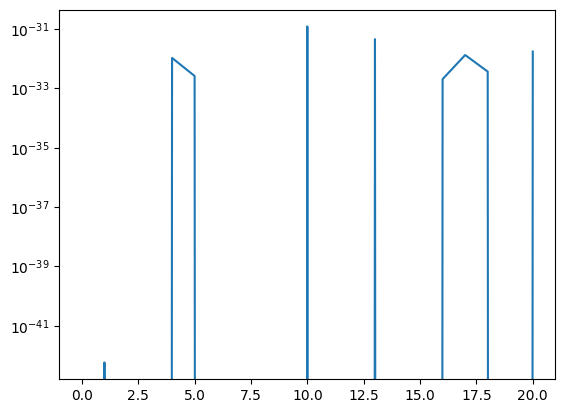

In [156]:
plt.plot(x_correlations[0, ::2])

plt.yscale('log')

In [193]:
test_corr = x_correlations[1, ::2]

In [194]:
sub_test_corr = test_corr[test_corr>1e-16]

In [195]:
len(sub_test_corr)

7

In [196]:
test_corr

array([ 4.91143584e-16,  3.12500000e-04,  7.81247539e-07,  2.93211962e-09,
        1.22345268e-11,  5.20782419e-14,  2.21827764e-16,  9.75781955e-19,
       -8.67361738e-19,  4.33680869e-19, -6.50521303e-19, -3.25260652e-19,
        1.40946282e-18, -5.42101086e-19, -4.33680869e-19, -2.16840434e-19,
       -1.08420217e-19,  0.00000000e+00,  5.42101086e-19,  4.33680869e-19,
        9.75781955e-19])

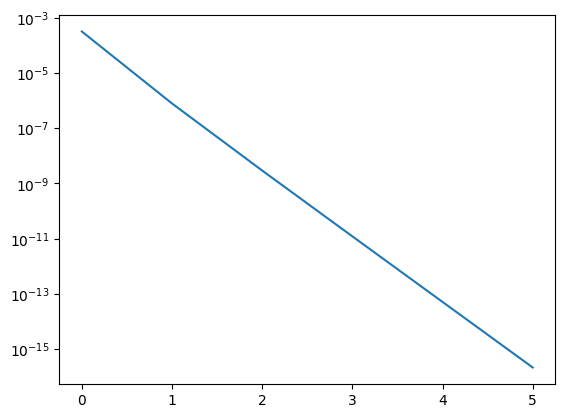

In [197]:
plt.plot(sub_test_corr[1:])
plt.yscale('log')

In [198]:
len(sub_test_corr)

7

In [200]:
1/((np.log(sub_test_corr[1]) - np.log(sub_test_corr[-1]))/(2*6))

0.4289739848065787

In [201]:
test_corr = x_correlations[2, ::2]

In [202]:
sub_test_corr = test_corr[test_corr>1e-16]

In [203]:
len(sub_test_corr)

8

In [204]:
test_corr

array([-3.79037080e-16,  1.25000000e-03,  1.24993541e-05,  1.88115074e-07,
        3.15324379e-09,  5.39477035e-11,  9.26293764e-13,  1.59104500e-14,
        2.71050543e-16,  1.73472348e-18, -4.33680869e-18, -5.63785130e-18,
       -6.50521303e-18, -7.80625564e-18, -3.03576608e-18, -9.97465999e-18,
       -5.20417043e-18, -1.47451495e-17,  2.94902991e-17, -9.54097912e-18,
       -2.42861287e-17])

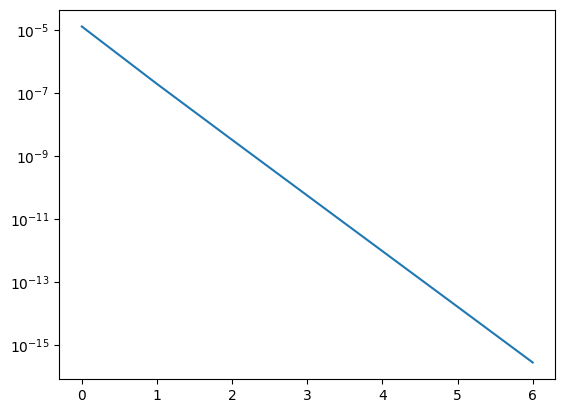

In [205]:
plt.plot(sub_test_corr[1:])
plt.yscale('log')

In [206]:
len(sub_test_corr)

8

In [207]:
1/((np.log(sub_test_corr[1]) - np.log(sub_test_corr[-1]))/(2*7))

0.5701627455264376

In [208]:
test_corr = x_correlations[3, ::2]

In [209]:
sub_test_corr = test_corr[test_corr>1e-16]

In [210]:
len(sub_test_corr)

10

In [211]:
test_corr

array([-8.85576334e-16,  2.81250000e-03,  6.32639794e-05,  2.15114486e-06,
        8.17264357e-08,  3.17186972e-09,  1.23569805e-10,  4.81721954e-12,
        1.87815041e-13,  7.31966571e-15,  2.83627288e-16,  9.54097912e-18,
       -5.20417043e-18, -8.06646416e-17, -8.67361738e-18, -4.33680869e-18,
       -5.20417043e-18, -1.73472348e-18,  8.67361738e-19,  3.46944695e-18,
        2.60208521e-18])

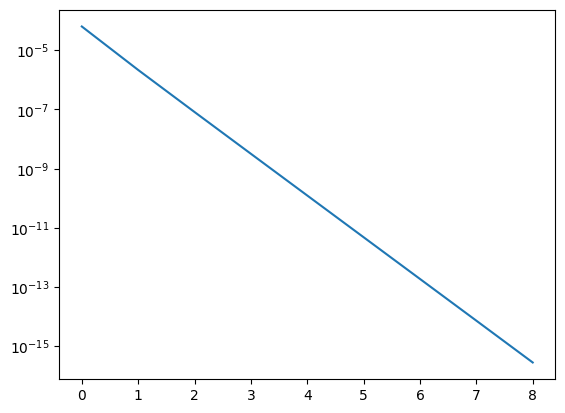

In [212]:
plt.plot(sub_test_corr[1:])
plt.yscale('log')

In [213]:
len(sub_test_corr)

10

In [214]:
1/((np.log(sub_test_corr[1]) - np.log(sub_test_corr[-1]))/(2*9))

0.688845548596736

# Correlations of other operators

In [215]:
y_exps = np.array([
    psi.expectation_value('Sy') for psi in psi_dict.values()
])

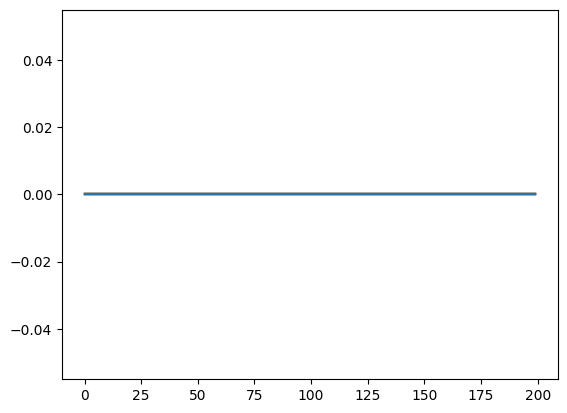

In [216]:
for l in y_exps:
    plt.plot(l)

In [217]:
z_exps = np.array([
    psi.expectation_value('Sz') for psi in psi_dict.values()
])

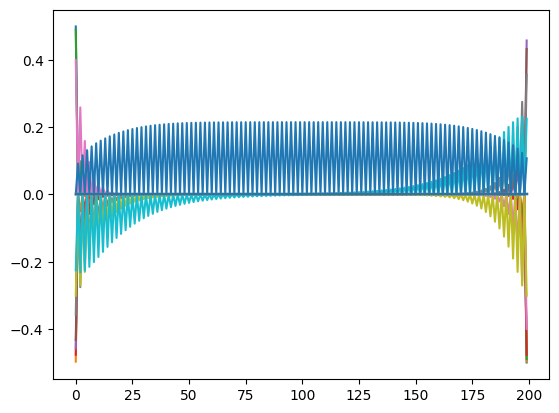

In [218]:
for l in z_exps:
    plt.plot(l)

In [219]:
def get_two_point_y_expectation(psi, distance):
    ops = ['Sy',] + ['Id',]*(distance-1) + ['Sy']

    return psi.expectation_value_multi_sites(ops, 80)

In [220]:
def get_two_point_z_expectation(psi, distance):
    ops = ['Sz',] + ['Id',]*(distance-1) + ['Sz']

    return psi.expectation_value_multi_sites(ops, 80)

In [221]:
y_2_points = np.array([
    [get_two_point_y_expectation(psi, d) for d in range(41)]
    for psi in psi_dict.values()
])

In [222]:
z_2_points = np.array([
    [get_two_point_z_expectation(psi, d) for d in range(41)]
    for psi in psi_dict.values()
])

In [223]:
z_correlations = (
    z_2_points
    - z_exps[:,80:81]*z_exps[:,80:121]
)

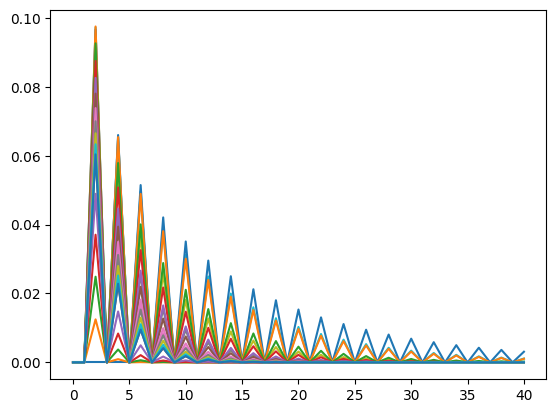

In [225]:
for l in z_correlations:
    plt.plot(l)

In [226]:
y_correlations = (
    y_2_points
    - y_exps[:,80:81]*y_exps[:,80:121]
)

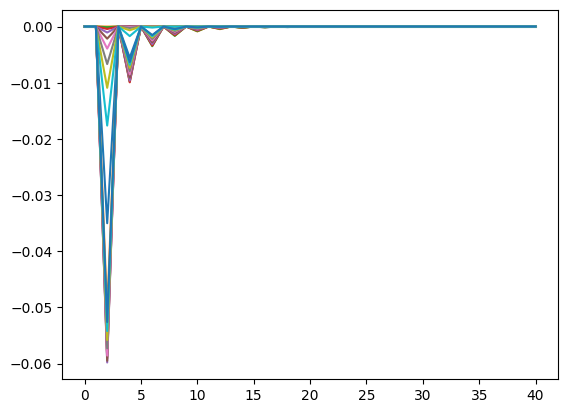

In [227]:
for l in y_correlations:
    plt.plot(l)

So try using Z

## From Z expectation values

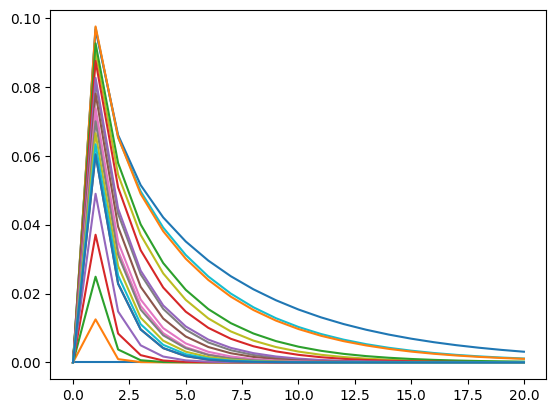

In [228]:
for l in z_correlations:
    plt.plot(l[::2])

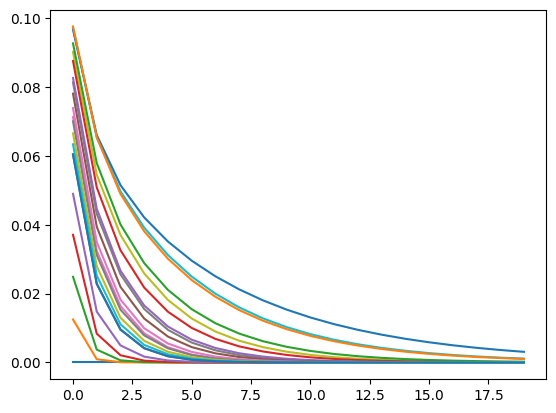

In [229]:
for l in z_correlations:
    plt.plot(l[2::2])

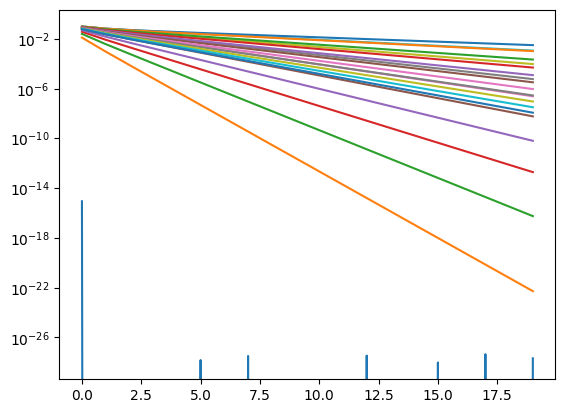

In [230]:
for l in z_correlations:
    plt.plot(l[2::2])

plt.yscale('log')

In [231]:
z_correlations.shape

(21, 41)

In [236]:
z_correlation_lengths = 38/np.log(z_correlations[:,2]/z_correlations[:,40])

In [237]:
z_correlation_lengths[0] = 0

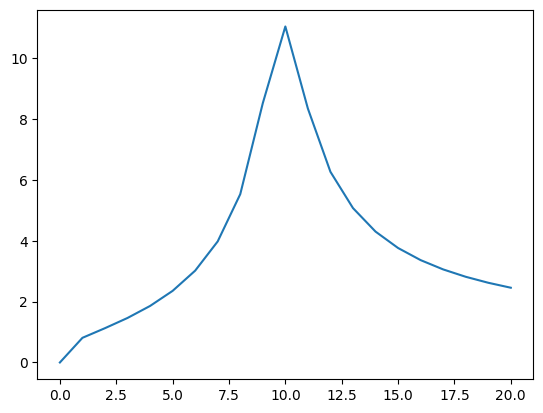

In [238]:
plt.plot(z_correlation_lengths)

In [239]:
with open(r'make_plots/data/200_site_mps_z_correlation_lengths.pkl', 'wb') as f:
    pickle.dump(
        {
            'b_parameters': list(psi_dict.keys()),
            'correlation_lengths': z_correlation_lengths
        },
        f
    )